In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/step2_features_summary.csv')
print(df.columns)
df = df[['Location', 'Time', 'GDP pct change prev yr', 'Inflation annual growth rate', 'PPI annual growth rate', 'Unemployment pct change', 'House price to income pct change', 'House price to rent pct change', 'Rent to income pct change', 'HH Debt pct change']]
df.head()

Index(['Location', 'Time', 'GDP pct change prev yr',
       'Inflation annual growth rate', 'PPI annual growth rate',
       'Unemployment', 'Unemployment pct change', 'House price to income',
       'House price to rent', 'Rent to income',
       'House price to income pct change', 'House price to rent pct change',
       'Rent to income pct change', 'HH Debt', 'HH Debt pct change',
       'Govt deficit to GDP', 'new value', 'Govt deficit to GDP interp'],
      dtype='object')


,Location,Time,GDP pct change prev yr,Inflation annual growth rate,PPI annual growth rate,Unemployment pct change,House price to income pct change,House price to rent pct change,Rent to income pct change,HH Debt pct change
0,DEU,1961-03-31 23:59:59.999999999,7.450290,1.806084,NaN,NaN,NaN,NaN,NaN,NaN
1,DEU,1961-06-30 23:59:59.999999999,5.002099,1.984877,NaN,NaN,NaN,NaN,NaN,NaN
2,DEU,1961-09-30 23:59:59.999999999,3.576950,2.646503,NaN,NaN,NaN,NaN,NaN,NaN
3,DEU,1961-12-31 23:59:59.999999999,2.996161,2.733270,NaN,NaN,NaN,NaN,NaN,NaN
4,DEU,1962-03-31 23:59:59.999999999,3.466854,3.361345,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Location                          9331 non-null   object 
 1   Time                              9331 non-null   object 
 2   GDP pct change prev yr            9331 non-null   float64
 3   Inflation annual growth rate      8726 non-null   float64
 4   PPI annual growth rate            3773 non-null   float64
 5   Unemployment pct change           4817 non-null   float64
 6   House price to income pct change  4625 non-null   float64
 7   House price to rent pct change    4625 non-null   float64
 8   Rent to income pct change         4625 non-null   float64
 9   HH Debt pct change                761 non-null    float64
dtypes: float64(8), object(2)
memory usage: 729.1+ KB


In [4]:
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time'])
df['Time'].head()

0   1961-03-31
1   1961-06-30
2   1961-09-30
3   1961-12-31
4   1962-03-31
Name: Time, dtype: datetime64[ns]

# NEED HELP
Set multiple index

Let's analyze USA from 1970 onwards and see if we can spot any patterns.

In [5]:
df_usa = df[(df['Location'] == 'USA') & (df['Time'].dt.year > 1970)]
df_usa

,Location,Time,GDP pct change prev yr,Inflation annual growth rate,PPI annual growth rate,Unemployment pct change,House price to income pct change,House price to rent pct change,Rent to income pct change,HH Debt pct change
7177,USA,1971-03-31,2.697244,5.000000,2.640546,36.363636,-1.525136,0.048553,-1.572926,NaN
7178,USA,1971-06-30,3.106623,4.400345,3.495313,20.408163,0.396426,4.608784,-4.026773,NaN
7179,USA,1971-09-30,3.005897,4.351536,3.305086,11.111111,1.011275,4.211423,-3.070823,NaN
7180,USA,1971-12-31,4.367208,3.451179,2.859547,-1.639344,1.428681,5.947905,-4.265515,NaN
7181,USA,1972-03-31,3.476072,3.425230,2.904563,-3.333333,0.324358,2.496374,-2.119115,NaN
...,...,...,...,...,...,...,...,...,...,...
7373,USA,2020-03-31,0.319261,2.118652,-0.528019,15.789474,3.520879,2.332978,1.160820,NaN
7374,USA,2020-06-30,-9.032775,0.364296,-5.056274,208.333333,-5.785960,2.373505,-7.970290,NaN
7375,USA,2020-09-30,-2.848345,1.222386,-1.966768,122.857143,0.935198,5.089929,-3.953501,NaN
7376,USA,2020-12-31,-2.386694,1.239488,-0.780322,86.111111,5.977428,8.229647,-2.080963,NaN


### Missing value

In [6]:
# count missing values in df
missing = pd.concat([df_usa.isnull().sum(), df_usa.isnull().mean()*100], axis=1)
missing.columns=['counts', '%']
missing.sort_values(by='%', ascending=False)

,counts,%
HH Debt pct change,178,88.557214
Location,0,0.000000
Time,0,0.000000
GDP pct change prev yr,0,0.000000
Inflation annual growth rate,0,0.000000
PPI annual growth rate,0,0.000000
Unemployment pct change,0,0.000000
House price to income pct change,0,0.000000
House price to rent pct change,0,0.000000
Rent to income pct change,0,0.000000


In [7]:
df_usa.describe()

,GDP pct change prev yr,Inflation annual growth rate,PPI annual growth rate,Unemployment pct change,House price to income pct change,House price to rent pct change,Rent to income pct change,HH Debt pct change
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,23.000000
mean,2.677427,3.898003,3.409719,2.979793,-0.298827,0.541894,-0.792661,0.525465
std,2.343230,2.957030,4.333715,25.452470,3.666555,3.964238,2.557289,3.956395
min,-9.032775,-1.623360,-8.346943,-28.712871,-12.158296,-11.926780,-13.633226,-5.649955
25%,1.609346,1.966925,0.854139,-10.204082,-2.194560,-1.254738,-2.065818,-2.753990
50%,2.821302,3.093249,2.859547,-5.357143,-0.002199,1.204297,-0.918259,1.217712
75%,4.192821,4.529973,5.397727,8.620690,2.215521,2.978778,0.497550,3.604593
max,8.578274,14.505600,18.670440,208.333333,9.008697,10.481031,9.707243,7.184707


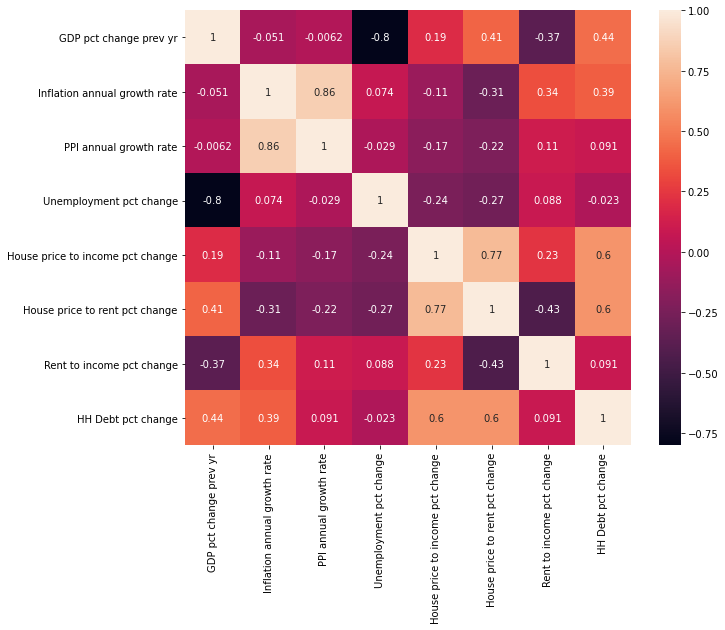

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df_usa.corr(), annot=True)

We can see that unemployment pct change is highly negatively correlated with GDP pct change. It is logical, because high unemployment rate will lead to low income and spending, thus temporary economy stagnation.

Household debt, housing price to rent and housing price to income are positively corrected with GDP. This seems reasonable too, as higher household debt is usually caused by higher borrowing for spending/investing, which stimulate the economy growth. Higher housing price is most likely related to GDP growth. Higher GDP growth usually refers to higher asset appreciation.

Rent to income is negatively correlated to GDP. Perhaps it can be explained by lowering GDP does not usually adjust lower rent. At the beginning of the recession, rent is usually at its peak and waiting to be adjusted subsequently.

I am surprised that inflation and PPI growths are not correlated with GDP growth.

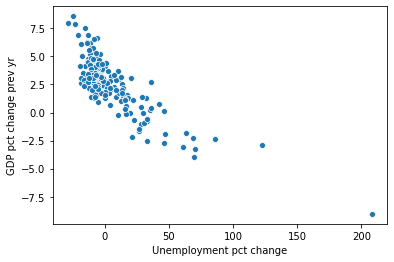

In [9]:
sns.scatterplot(x='Unemployment pct change', y='GDP pct change prev yr', data=df_usa)

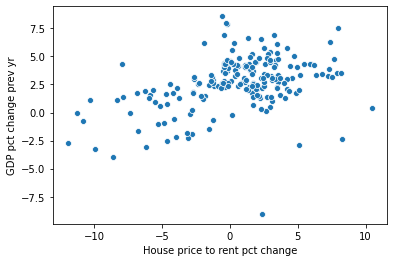

In [10]:
sns.scatterplot(x='House price to rent pct change', y='GDP pct change prev yr', data=df_usa)

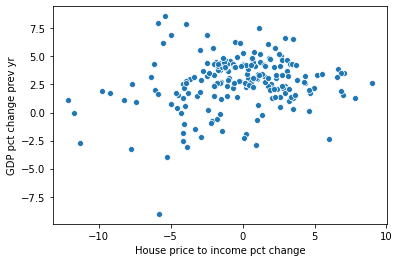

In [11]:
sns.scatterplot(x='House price to income pct change', y='GDP pct change prev yr', data=df_usa)

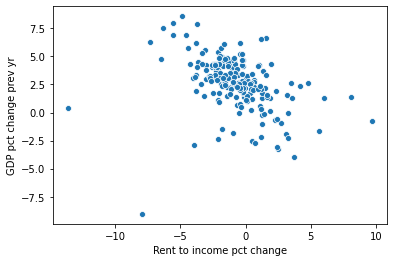

In [12]:
sns.scatterplot(x='Rent to income pct change', y='GDP pct change prev yr', data=df_usa)

### PCA transformation

In [15]:
df_usa = df_usa[~df_usa['Location', 'Time', 'HH Debt pct change']]

KeyError: ('Location', 'Time', 'HH Debt pct change')

In [14]:
df_usa = df_usa[feat_cols].drop(columns='HH Debt pct change', axis=1, inplace=True)
df_usa

In [15]:
df_usa_scale = scale(df_usa)

TypeError: Singleton array array(nan) cannot be considered a valid collection.

In [ ]:
pca = PCA().fit(df_usa_scale)